
# Finite Differences via the Method of Moments
*A practical, code-backed explanation*  
Created: 2025-08-22



## Overview
We want coefficients $c_j$ such that a linear combination of nearby function samples
approximates a derivative of order $d$ at a point $x$:
$$
  f^{(d)}(x) \approx \frac{1}{h^d} \sum_{j=1}^m c_j\, f(x + s_j h),
$$
where $h$ is the grid spacing and $s_j$ are offsets in units of $h$ (e.g., $-2,-1,0,1,2$).

**Method of moments idea:** expand each sample in a Taylor series around $x$, then choose $c_j$
so that the first $m$ Taylor moments match the target derivative. That forces lower-order terms
to cancel and determines the **accuracy order** automatically.



## Taylor expansion and moment conditions
Taylor expand a sample:
$$
f(x+s_j h) = \sum_{k=0}^{\infty} \frac{f^{(k)}(x)}{k!} (s_j h)^k.
$$
Insert into the FD ansatz and collect by $f^{(k)}(x)$. To make the formula exact up to degree $m-1$:
$$
\sum_{j=1}^m c_j s_j^k =
\begin{cases}
0 & k=0,1,\dots,m-1,\; k\ne d,\\
d! & k=d.
\end{cases}
$$
These sums are the **moments**. Solving this $m\times m$ system yields the stencil $c_j$.
The first higher moment that does **not** vanish occurs at some $k^*\ge m$. Then the leading error is
$$
\text{TE} \sim \frac{\sum_j c_j s_j^{k^*}}{k^*!} \, h^{\,k^*-d} \, f^{(k^*)}(x).
$$
The **accuracy order** is $p = k^* - d$.



## Setup
Run this once per kernel.


In [1]:

import sympy as sp
import numpy as np
sp.__version__


'1.10.1'


## Helper functions (symbolic)
- `fd_weights(offsets, d)`: solve the moment system for coefficients.
- `leading_error_constant(offsets, d)`: compute accuracy order `p` and leading TE constant `C_p`.


In [2]:

def fd_weights(offsets, d):
    '''
    offsets: list of offsets s_j (can be non-integers), measured in steps of h
    d: derivative order (0,1,2,...)
    returns: sympy Matrix of coefficients c_j
    '''
    s = [sp.nsimplify(si) for si in offsets]
    m = len(s)
    A = sp.Matrix([[s[j]**k for j in range(m)] for k in range(m)])
    b = sp.Matrix([0]*m); b[d] = sp.factorial(d)
    c = A.LUsolve(b)
    return sp.simplify(c)

def leading_error_constant(offsets, d):
    '''
    Returns (p, C_p) where TE ~ C_p * h**p * f^(d+p)(x).
    '''
    s = [sp.nsimplify(si) for si in offsets]
    c = fd_weights(s, d)
    m = len(s)
    k = m
    while True:
        mom = sp.simplify(sum(c[j]*s[j]**k for j in range(m)))
        if mom != 0:
            p = k - d
            Cp = sp.simplify(mom/sp.factorial(k))
            return int(p), Cp
        k += 1



## Example 1 — 3-point second derivative (classic)
Offsets: $s = [-1, 0, 1]$, target $d=2$.
Expected stencil: $[1, -2, 1]$ with second-order accuracy and TE constant $1/12$.


In [3]:

c = fd_weights([-1,0,1], d=2)
p, C = leading_error_constant([-1,0,1], d=2)
print("weights:", list(c))
print("order p:", p, "  TE constant C_p:", C)
assert list(c) == [1, -2, 1]
assert p == 2 and sp.simplify(C - sp.Rational(1,12)) == 0


weights: [1, -2, 1]
order p: 2   TE constant C_p: 1/12



## Example 2 — 5-point, 4th-order first derivative
Offsets: $s = [-2,-1,0,1,2]$, target $d=1$.  
Stencil should be
$$
\frac{1}{12h}\big[f(x-2h) - 8 f(x-h) + 8 f(x+h) - f(x+2h)\big],
$$
i.e. coefficients $[1/12, -2/3, 0, 2/3, -1/12]$, order 4, leading constant $-1/30$.


In [4]:

c = fd_weights([-2,-1,0,1,2], d=1)
p, C = leading_error_constant([-2,-1,0,1,2], d=1)
print("weights:", list(c))
print("order p:", p, "  TE constant C_p:", C)
assert list(c) == [sp.Rational(1,12), -sp.Rational(2,3), 0, sp.Rational(2,3), -sp.Rational(1,12)]
assert p == 4 and sp.simplify(C + sp.Rational(1,30)) == 0


weights: [1/12, -2/3, 0, 2/3, -1/12]
order p: 4   TE constant C_p: -1/30



## Nonuniform and one-sided examples
The same system works if the offsets are one-sided or nonuniform.


In [5]:

# One-sided first derivative at a boundary: offsets [0,1,2,3] (third-order accurate)
c_os = fd_weights([0,1,2,3], d=1)
p_os, C_os = leading_error_constant([0,1,2,3], d=1)
print("one-sided d=1 weights:", list(c_os))
print("order:", p_os, "  TE const:", C_os)

# A simple nonuniform first-derivative stencil: offsets [0, 1/2, 3/2]
c_nu = fd_weights([0, sp.Rational(1,2), sp.Rational(3,2)], d=1)
p_nu, C_nu = leading_error_constant([0, sp.Rational(1,2), sp.Rational(3,2)], d=1)
print("nonuniform d=1 weights:", list(c_nu))
print("order:", p_nu, "  TE const:", C_nu)


one-sided d=1 weights: [-11/6, 3, -3/2, 1/3]
order: 3   TE const: 1/4
nonuniform d=1 weights: [-8/3, 3, -1/3]
order: 2   TE const: -1/8



## Automatic exactness test on polynomials
A stencil that matches moments up to degree $m-1$ (aside from $k=d$) differentiates polynomials
exactly up to that degree. The helper below checks this by comparing the FD approximation
to the exact derivative on a **generic polynomial**.


In [6]:

def test_stencil_exactness(offsets, d, maxdeg=None):
    '''
    Returns a simplified series-in-h of the error for a generic polynomial;
    identically 0 up to the enforced degree means the stencil is exact there.
    '''
    s = [sp.nsimplify(si) for si in offsets]
    m = len(s)
    if maxdeg is None:
        maxdeg = m-1
    x, h = sp.symbols('x h')
    a = sp.symbols('a0:'+str(maxdeg+1))
    p = sum(a[k]*x**k for k in range(maxdeg+1))
    c = fd_weights(s, d)
    fd = sum(c[j]*p.subs(x, x + s[j]*h) for j in range(m)) / (h**d)
    exact = sp.diff(p, x, d)
    diff_series = sp.series(sp.simplify(fd - exact), h, 0, m).removeO()
    return sp.simplify(diff_series)

# Should be identically 0 for the 5-point first-derivative stencil up to degree 4 (except k=1 behavior)
test_stencil_exactness([-2,-1,0,1,2], d=1)


0


## Sanity check vs. a known function
Take $f(x)=\sin x$, so $f'(x)=\cos x$. Compare the 5-point stencil to the truth at $x=1$.


In [7]:

import math
x0 = 1.0
h = 1e-3
offs = [-2,-1,0,1,2]
c = fd_weights(offs, d=1)
approx = sum(c[j]*math.sin(x0 + offs[j]*h) for j in range(len(offs))) / h
print("FD approx:", approx)
print("true     :", math.cos(1.0))
print("abs error:", abs(approx - math.cos(1.0)))


FD approx: 0.540302305868073
true     : 0.5403023058681398
abs error: 6.63913368725844e-14



## Cheat sheet (how to derive any stencil)
1. Pick offsets `s = [s1, ..., sm]` and derivative order `d`.
2. Build `A[k, j] = s_j**k` for `k=0..m-1` and `b = [0,...,0]` with `b[d] = d!`.
3. Solve `A c = b` to get coefficients `c_j`.
4. The accuracy order is `p = k* - d`, where `k*` is the first integer `>= m` with nonzero moment `sum(c_j * s_j**k*)`.
   The leading truncation error is `TE ~ (sum c_j s_j**k*)/k!* h**p * f^(d+p)(x)`.



## Exercises
1. Derive a fourth-order second-derivative stencil using offsets `[-2,-1,0,1,2]`. Report its order and TE constant.  
2. Build a one-sided second-derivative stencil at a boundary using offsets `[0,1,2,3]`. What order do you get?  
3. Try a nonuniform first-derivative stencil with offsets `[0, 1/3, 1]`. Verify exactness on polynomials up to the expected degree.  
4. Use your favorite smooth function and check the absolute error of your stencils for several `h` values; plot error vs `h` to estimate the observed order.



## Deeper intuition: moments, symmetry, and why cancellations happen
- The coefficients `c_j` (scaled by `1/h^d`) act like a **discrete derivative of the delta**: testing on monomials `x^k` gives the moments `Σ c_j s_j^k`.
- For **symmetric offsets** (e.g., `[-2,-1,0,1,2]`), odd powers of `s` are odd functions and even powers are even functions.  
  - For a **first derivative** (odd operator), the solution `c` is **antisymmetric** and the central coefficient is zero.
  - For a **second derivative** (even operator), the solution `c` is **symmetric**.
- Because of symmetry, many moments **vanish automatically** (e.g., all odd moments for an even stencil), boosting the order without increasing unknowns.



## Worked derivation (by hand, symbolically verified): 3-point second derivative
We will build `A c = b` explicitly for offsets `s = [-1, 0, 1]` and `d = 2`.


In [8]:

import sympy as sp
s = [-1, 0, 1]
m, d = len(s), 2
A = sp.Matrix([[sp.Integer(s[j])**k for j in range(m)] for k in range(m)])
b = sp.Matrix([0]*m); b[d] = sp.factorial(d)
c = A.LUsolve(b)
A, b, sp.simplify(c)


(Matrix([
 [ 1, 1, 1],
 [-1, 0, 1],
 [ 1, 0, 1]]),
 Matrix([
 [0],
 [0],
 [2]]),
 Matrix([
 [ 1],
 [-2],
 [ 1]]))


## Worked derivation: 5-point, fourth-order first derivative
Offsets `s = [-2,-1,0,1,2]`, target `d=1`. We construct the moment system and verify the solution.


In [9]:

s = [-2,-1,0,1,2]
m, d = len(s), 1
A = sp.Matrix([[sp.Integer(s[j])**k for j in range(m)] for k in range(m)])
b = sp.Matrix([0]*m); b[d] = sp.factorial(d)
c = sp.simplify(A.LUsolve(b))
A, b, list(c)


(Matrix([
 [ 1,  1, 1, 1,  1],
 [-2, -1, 0, 1,  2],
 [ 4,  1, 0, 1,  4],
 [-8, -1, 0, 1,  8],
 [16,  1, 0, 1, 16]]),
 Matrix([
 [0],
 [1],
 [0],
 [0],
 [0]]),
 [1/12, -2/3, 0, 2/3, -1/12])

In [10]:

# Check symmetry/antisymmetry properties automatically
def is_symmetric(vec):
    return all(sp.simplify(vec[i] - vec[-1-i]) == 0 for i in range(len(vec)))
def is_antisymmetric(vec):
    return all(sp.simplify(vec[i] + vec[-1-i]) == 0 for i in range(len(vec)))

print("symmetric?", is_symmetric(list(c)))
print("antisymmetric?", is_antisymmetric(list(c)))


symmetric? False
antisymmetric? True



## Symmetry rules (quick demo)
For symmetric offsets and even `d`, the solution is symmetric; for odd `d`, it is antisymmetric.  
This helps predict zero coefficients (e.g., the center coefficient for `d=1` is 0).


In [11]:

def fd_weights(offsets, d):
    s = [sp.nsimplify(si) for si in offsets]
    m = len(s)
    A = sp.Matrix([[s[j]**k for j in range(m)] for k in range(m)])
    b = sp.Matrix([0]*m); b[d] = sp.factorial(d)
    return sp.simplify(A.LUsolve(b))

for d in [1,2]:
    c = list(fd_weights([-2,-1,0,1,2], d=d))
    print(f"d={d}  weights:", c, "  center =", c[len(c)//2])


d=1  weights: [1/12, -2/3, 0, 2/3, -1/12]   center = 0
d=2  weights: [-1/12, 4/3, -5/2, 4/3, -1/12]   center = -5/2



## One-sided stencils at boundaries and ghost-point elimination
Two common ways to handle boundaries:
1. **One-sided stencil** (no ghost unknowns). Example: d=1 at `x=0` with offsets `[0,1,2,3]` (third-order accurate).
2. **Ghost-point relation** with a centered stencil. Example: Neumann `u'(0)=g` with centered stencil `(u_1 - u_{-1})/(2h) = g` ⇒ `u_{-1} = u_1 - 2 h g`.
Below we show (1) via moments and (2) via a direct algebraic relation.


In [12]:

# (1) One-sided d=1 with offsets [0,1,2,3]
c_os = fd_weights([0,1,2,3], d=1)
p_os = None; C_os = None
# quick inspector for order/TE constant
def leading_error_constant(offsets, d):
    s = [sp.nsimplify(si) for si in offsets]
    c = fd_weights(s, d)
    m = len(s)
    k = m
    while True:
        mom = sp.simplify(sum(c[j]*s[j]**k for j in range(m)))
        if mom != 0:
            return k - d, sp.simplify(mom/sp.factorial(k))
        k += 1

p_os, C_os = leading_error_constant([0,1,2,3], d=1)
print("one-sided d=1 weights:", list(c_os))
print("order:", p_os, "  TE const:", C_os)


one-sided d=1 weights: [-11/6, 3, -3/2, 1/3]
order: 3   TE const: 1/4


In [13]:

# (2) Ghost-point elimination for Neumann: (u_1 - u_{-1})/(2h) = g  ⇒ u_{-1} = u_1 - 2 h g
import sympy as sp
u1, h, g = sp.symbols('u1 h g')
u_minus1 = sp.simplify(u1 - 2*h*g)
u_minus1


-2*g*h + u1


## Cookbook: common central stencils (uniform grid)
- d=1, 2nd order, 3-point: `[ -1/2, 0, 1/2 ] / h`
- d=1, 4th order, 5-point: `[ 1/12, -2/3, 0, 2/3, -1/12 ] / h`
- d=2, 2nd order, 3-point: `[ 1, -2, 1 ] / h^2`
- d=2, 4th order, 5-point: `[ -1/12, 4/3, -5/2, 4/3, -1/12 ] / h^2`
Use the method of moments to regenerate/verify any of these.



## Building sparse FD matrices automatically
Create a matrix for interior unknowns using given offsets. This is handy for method-of-lines or PDE solvers.


In [14]:

import numpy as np
from scipy.sparse import diags

def fd_operator_matrix(n, h, offsets, d):
    c = [float(sp.nsimplify(ci)) for ci in fd_weights(offsets, d)]
    data = []
    diagonals = []
    for s, cj in zip(offsets, c):
        k = int(s)  # offset is assumed integer here for the matrix pattern
        length = n - abs(k)
        if length <= 0:
            continue
        data.append((cj / (h**d)) * np.ones(length))
        diagonals.append(k)
    A = diags(data, diagonals, shape=(n, n))
    return A

# Demo: 5-point 2nd derivative (4th order) on n interior points
A = fd_operator_matrix(n=50, h=1/51, offsets=[-2,-1,0,1,2], d=2)
A.shape, A.nnz


((50, 50), 244)


## Dispersion view: modified wavenumber for first-derivative stencils
For a Fourier mode `e^{i k x_i}`, a discrete first-derivative operator produces `(i k_tilde) e^{i k x_i}` with
\[
k_{\text{tilde}} h = \frac{1}{i}\sum_j c_j e^{i s_j (kh)}.
\]
We compare `k_tilde/k` vs `kh` for the 2nd- and 4th-order central stencils.


/var/folders/r3/b5v1s0gd7kq5f6lbp7zb_4rr0000gn/T/ipykernel_89172/3459026878.py:10: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.real(ktilde_h / thetas)  # ratio of ktilde/k (avoid theta=0 separately)
/var/folders/r3/b5v1s0gd7kq5f6lbp7zb_4rr0000gn/T/ipykernel_89172/3459026878.py:10: RuntimeWarning: divide by zero encountered in true_divide
  ratio = np.real(ktilde_h / thetas)  # ratio of ktilde/k (avoid theta=0 separately)


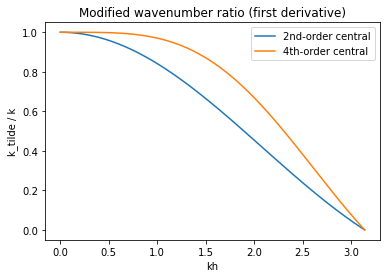

In [15]:

import numpy as np
import matplotlib.pyplot as plt

def modified_wavenumber_ratio(offsets, d, thetas):
    c = np.array([float(sp.nsimplify(ci)) for ci in fd_weights(offsets, d)], dtype=complex)
    s = np.array(offsets, dtype=float)
    # ktilde h = (1/i) * sum c_j * exp(i s_j theta)
    omega = np.exp(1j * np.outer(thetas, s)) @ c
    ktilde_h = (1.0/1j) * omega
    ratio = np.real(ktilde_h / thetas)  # ratio of ktilde/k (avoid theta=0 separately)
    ratio[0] = 1.0  # define limit at 0
    return ratio

thetas = np.linspace(0, np.pi, 400)
r2 = modified_wavenumber_ratio([-1,0,1], 1, thetas)   # 2nd-order central
r4 = modified_wavenumber_ratio([-2,-1,0,1,2], 1, thetas)  # 4th-order central

plt.figure()
plt.plot(thetas, r2, label="2nd-order central")
plt.plot(thetas, r4, label="4th-order central")
plt.xlabel("kh")
plt.ylabel("k_tilde / k")
plt.title("Modified wavenumber ratio (first derivative)")
plt.legend()



## Practice problems
1. Use `fd_operator_matrix` to build a 1D Laplacian with the 5-point 4th-order stencil and solve a Poisson problem with Dirichlet BCs. Verify the observed order.  
2. Derive a one-sided second-derivative stencil at `x=0` with offsets `[0,1,2,3]`. Compare its TE constant to the central 3-point stencil used one cell away from the wall.  
3. For the dispersion plot, add the 6th-order central first-derivative stencil and compare `k_tilde/k` across orders.  
4. Show that for symmetric offsets and odd `d`, the center coefficient must be zero (prove using the moment system).


*Extended on 2025-08-22 16:25:17*